In [4]:
import numpy as np
try:
    from jupyterthemes import jtplot
    jtplot.style()
except ImportError:
    pass
import matplotlib.pyplot as plt
%matplotlib notebook

from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion 
from scipy.ndimage.morphology import iterate_structure

# Finding Local Peaks in a 2D Array

## Toy Problem

We want to find the primary points of contact made by puppy-paws on a pressure-sensor. There are 4 images that are 11x14 pixesl. 

The pressure-heatmap data is given below:

In [5]:
paws = np.loadtxt('paws.txt').reshape(4, 11, 14)
print(paws.shape)

(4, 11, 14)


<IPython.core.display.Javascript object>


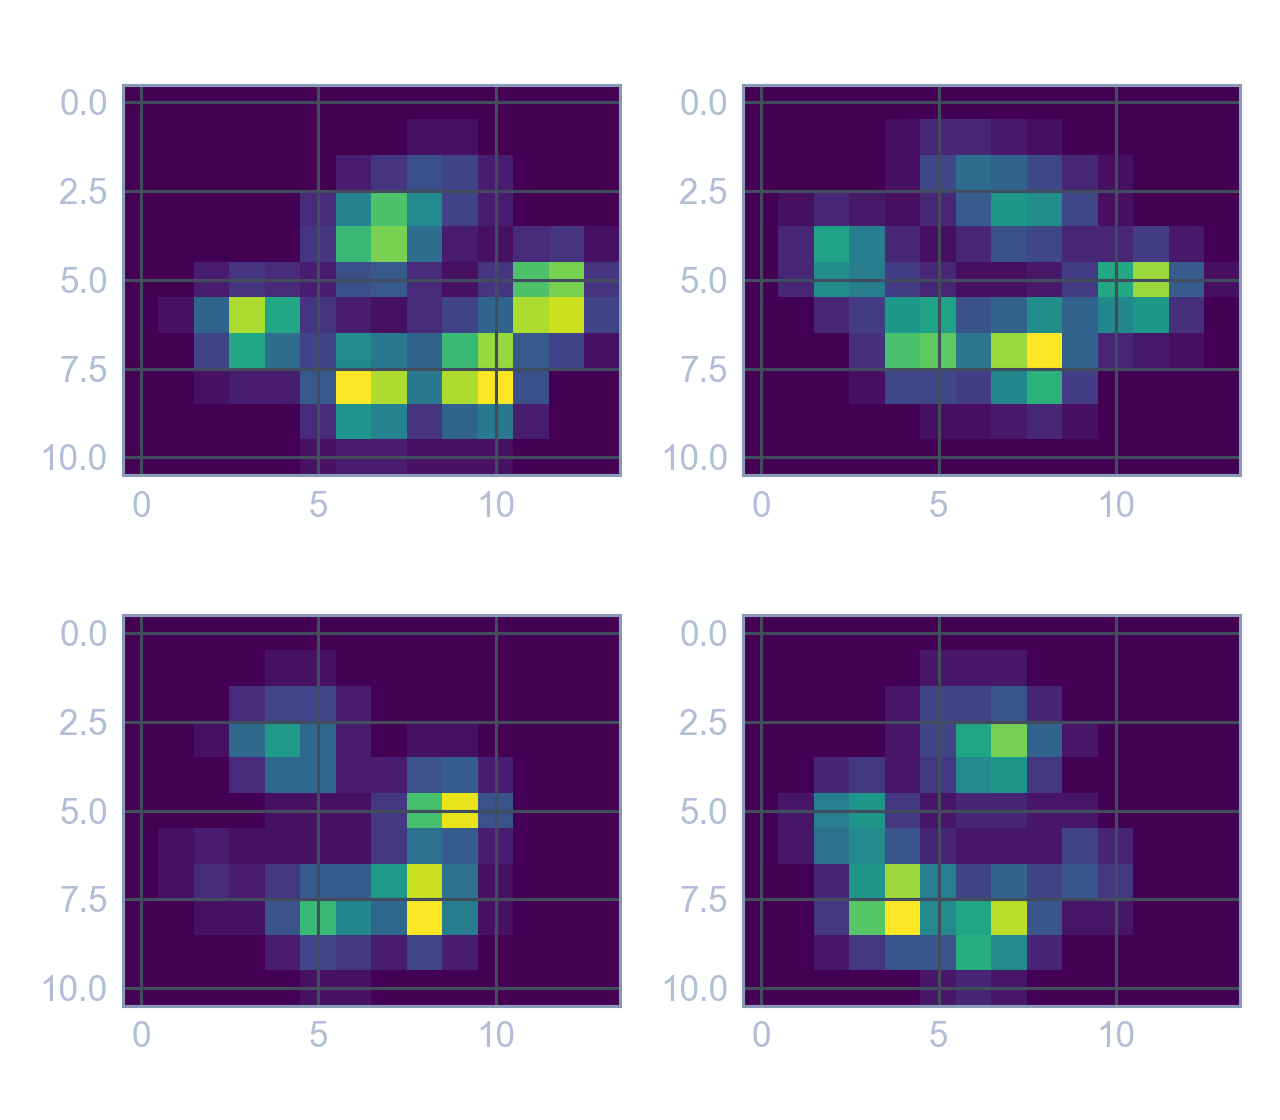

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2)
for n, (i,j) in enumerate([(0,0), (0,1), (1,0), (1,1)]):
    ax[i, j].imshow(paws[n]);

For each "toe", we want to find the pixel with the maximum pressure. This corresponds to a finding the local peaks in a 2D image. This is much more nuanced than finding the global maximum. It is also not completely well defined - we need to specify what we mean by local.

### generate_binary_structure

We will use `scipy.ndimage.morphologygenerate_binary_structure` to help us define the local neighborhood that we will consider, when looking for 2D peaks.

`generate_binary_structure` produces the footprint in which we look for neigbors. Using `generate_binary_structure(rank=2,connectivity=1)` means that, for a given pixel, we will check its two vertical and two horizontal neighbors when checking for the local maximum.


In [7]:
generate_binary_structure(rank=2,connectivity=1)

array([[False,  True, False],
       [ True,  True,  True],
       [False,  True, False]], dtype=bool)

<IPython.core.display.Javascript object>


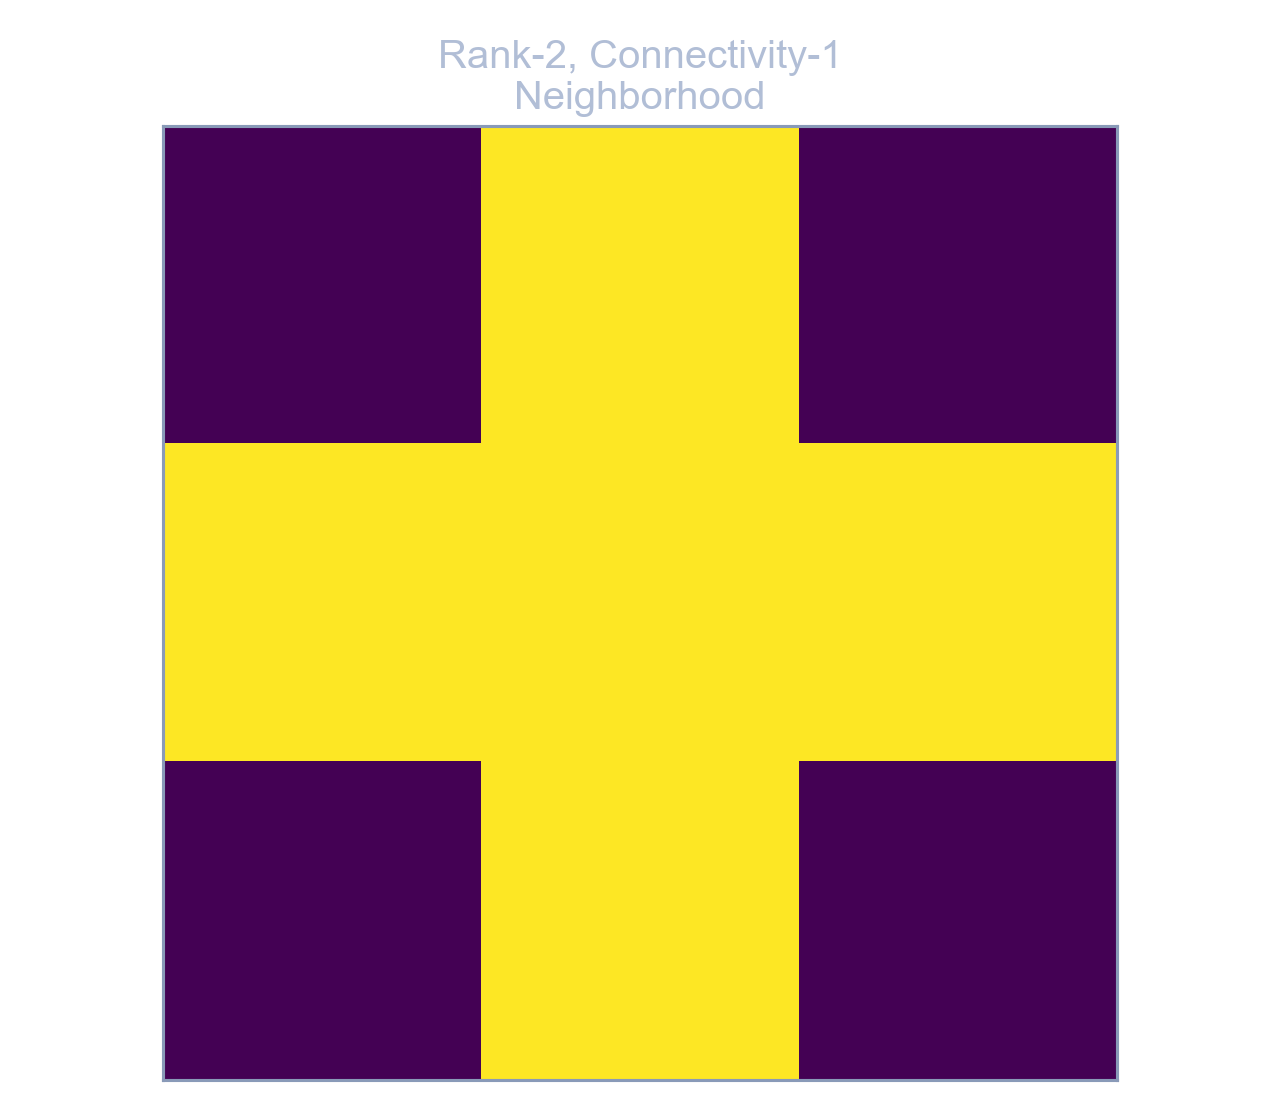

In [8]:
fig, ax = plt.subplots()
ax.imshow(generate_binary_structure(rank=2,connectivity=1))
ax.set_title("Rank-2, Connectivity-1\nNeighborhood")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([]);

What is the "footprint" produced by `generate_binary_structure(rank=2,connectivity=2)`?

Boolean arrays behave like a binary mask when multiplied with a numerical array. Try multiplying the connectivity-1, rank-2 binary structure with a (3, 3)-shaped array of 2s. Try to predict what the result will be before running your code.

In [9]:
2*np.ones((3, 3)) * generate_binary_structure(2, 1)

array([[ 0.,  2.,  0.],
       [ 2.,  2.,  2.],
       [ 0.,  2.,  0.]])

### maximum_filter
`scipy.ndimage.filters.maximum_filter` is able to take a binary strucure and use it to define a local "neighborhood", or "footprint" (wherever the footprint is `True`), within which it identifies the local maxima in an array. It rasters this footprint over our 2D array fith the footprint centered at each element, and produces a 2D array of the same shape, but whose elements contain the local max values.

For example, consider the array of data:
```python
data = np.array([[ 4,  0,  5],
                 [ 2,  9,  1],
                 [10, -2,  1]])
```

Given the binary foot print:
```python
fp = np.array([[False,  True, False],
               [ True,  True,  True],
               [False,  True, False]], dtype=bool)
```

Using this footprint, `maximum_filter` will look at the entry 4, above it, below it, to the left, and to the right, and will populate that position of the (3, 3) output array with the maximum in that footprint. Because there is no entry above 4, or to the left, `maximum_filter` will "mirror" the data across the boundary. This 'mode' of dealing with the boundary can be changed (see the docstring). The maximum value here is 4.

`maximum_filter` places the footprint centered at each element of the data array and populates the corresponding element of the output with the maximum value from the footprint. What will be the output of  `maximum_filter(data, footprint=fp)` be? Determine this by hand before running the code.

In [10]:
# SOLUTION
data = np.array([[ 4,  0,  5],
                 [ 2,  9,  1],
                 [10, -2,  1]])
fp = generate_binary_structure(2, 1)
maximum_filter(data, footprint=fp)

array([[ 4,  9,  5],
       [10,  9,  9],
       [10, 10,  1]])

Exercise: 

Given the data array
```python
data = np.array([[ 2,   14,  10,  5],
                 [ -1,  19,   1,  4],
                 [ 10,  -2,   7,  2],
                 [  9,   8,   4,  6]])
```

Find `fp` such that

```python
>>> maximum_filter(data, footprint=fp)
array([[19, 10, 19, 10],
       [14, 10, 14, 10],
       [19,  9, 19,  6],
       [10, 10,  8,  7]])
```

Hint: Start with the four elements in the middle of the output. Keep in mind how border cases are handled by default


In [13]:
# SOLUTION
old_fp = np.array([[False,  True, False],
                   [ True,  True,  True],
                   [False,  True, False]], dtype=bool)

# The symbol ~ is "not" in boolean logic: 
# ~True -> False,  ~False -> True
fp = ~old_fp
print(fp)

[[ True False  True]
 [False False False]
 [ True False  True]]


In [15]:
data = np.array([[ 2,   14,  10,  5],
                 [ -1,  19,   1,  4],
                 [ 10,  -2,   7,  2],
                 [  9,   8,   4,  6]])
maximum_filter(data, footprint=fp)

array([[19, 10, 19, 10],
       [14, 10, 14, 10],
       [19,  9, 19,  6],
       [10, 10,  8,  7]])

What if we want to use a larger footprint? We can make use of `scipy.ndimage.morphology.iterate_structure`. This allows us to set roughly the number of nearest neighbors (along a given direction) that that we want to included in the footprint.

For instance:
```python
>>> fp = generate_binary_structure(2,1)
>>> iterate_structure(fp, 2)
array([[False, False,  True, False, False],
       [False,  True,  True,  True, False],
       [ True,  True,  True,  True,  True],
       [False,  True,  True,  True, False],
       [False, False,  True, False, False]], dtype=bool)
```

<IPython.core.display.Javascript object>


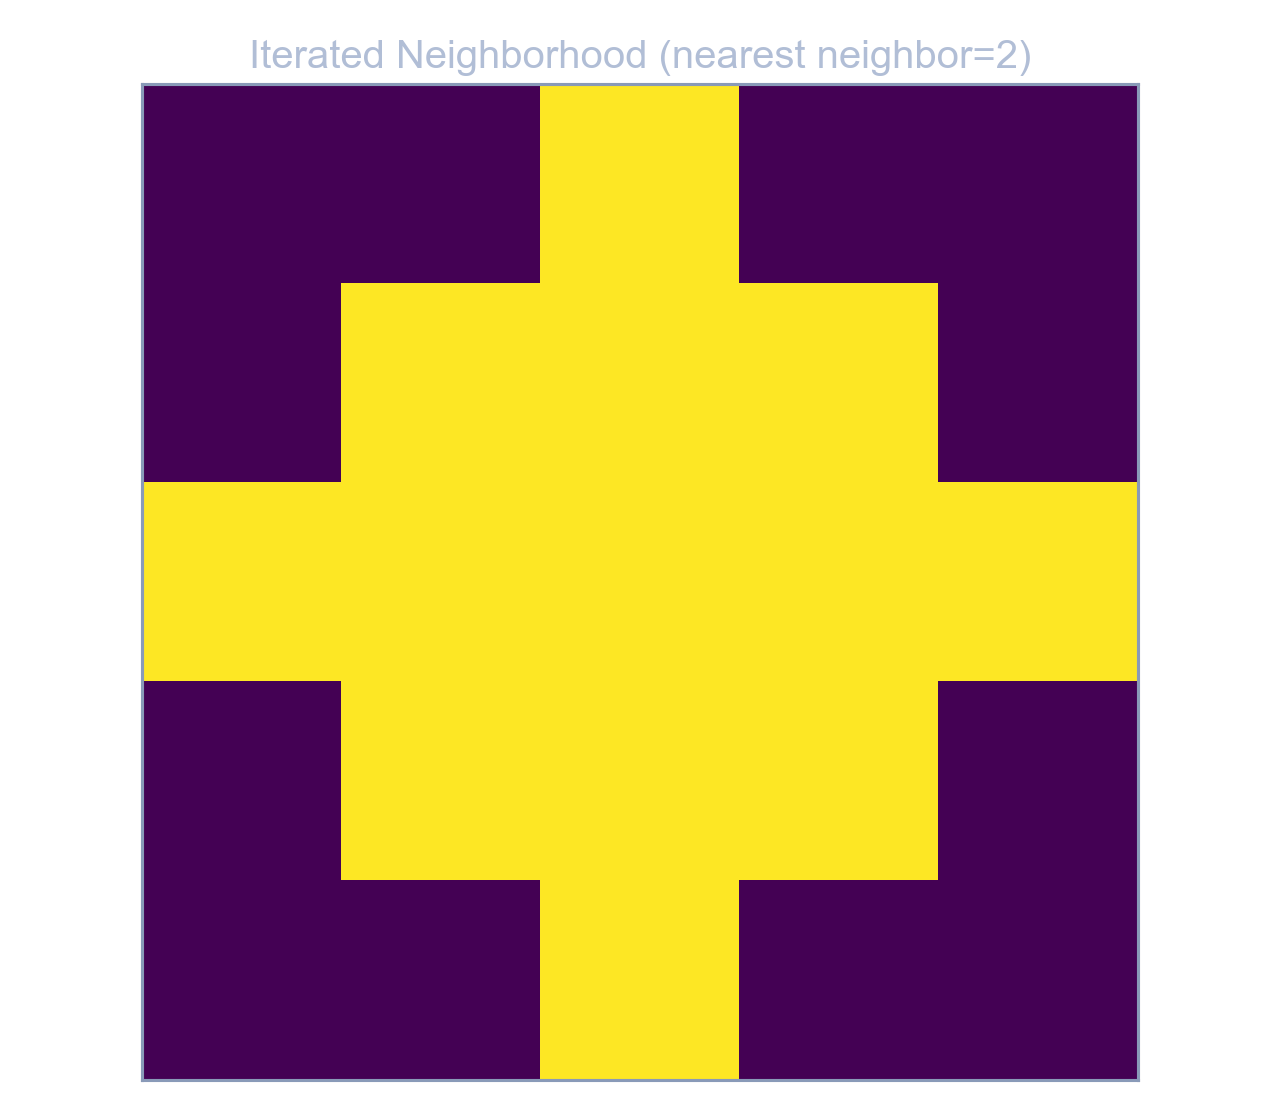

In [16]:
fig, ax = plt.subplots()
fp = generate_binary_structure(2,1)
ax.imshow(iterate_structure(fp, 2))
ax.set_title("Iterated Neighborhood (nearest neighbor=2)")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([]);

### Finding the Actual Peaks
What we are after are the local peaks in our data. `maximum_filter` essentially smears the local maxima over our data. We can simply see where our data matches with the max-filtered data - these points of agreement should be our local peaks!

That is
```python
peaks = (data == maximum_filter(data, footprint=fp))
```

`peaks` is thus an array of 1s wherever there is a local peak, and 0s elsewhere. Let's write a function that takes in a 2D array of data, and returns this bindary indicator of the local peaks in the data. Let's use the rank-2, connectivity-2 footprint. Call the function `local_peaks_v1`. Thus "local" here means a 3x3 neighborhood.

In [17]:
# SOLUTION
def local_peaks_v1(data):
    """ Find local peaks in a 2D array of data.
    
        Parameters
        ----------
        data : numpy.ndarray
        
        Returns
        -------
        Binary indicator, of the same shape as `data`. The value of
        1 indicates a local peak. """
    fp = generate_binary_structure(2, 2)
    return data == maximum_filter(data, footprint=fp)

Here is a function that will plot the paw prints next to the binary indicator of the local peaks.

In [18]:
def plot_compare(data, peak_finding_function):
    """ Plot the original data side-by-side with the binary indicator
        for the local peaks.
        
        Parameters
        ----------
        data : numpy.ndarray, shape=(N, H, W)
            N 2D arrays of shape (H, W)
            
        peak_finding_function : Callable[ndarray, ndarray]
            Returns local peak indicator for 2D array"""
    fig, ax = plt.subplots(nrows=len(data), ncols=2)
    for i, dat in enumerate(data):
        ax[i, 0].imshow(dat)
        ax[i, 1].imshow(peak_finding_function(dat))
    return fig, ax

Now plot a comparison to assess how well our peak-finding function works.

<IPython.core.display.Javascript object>


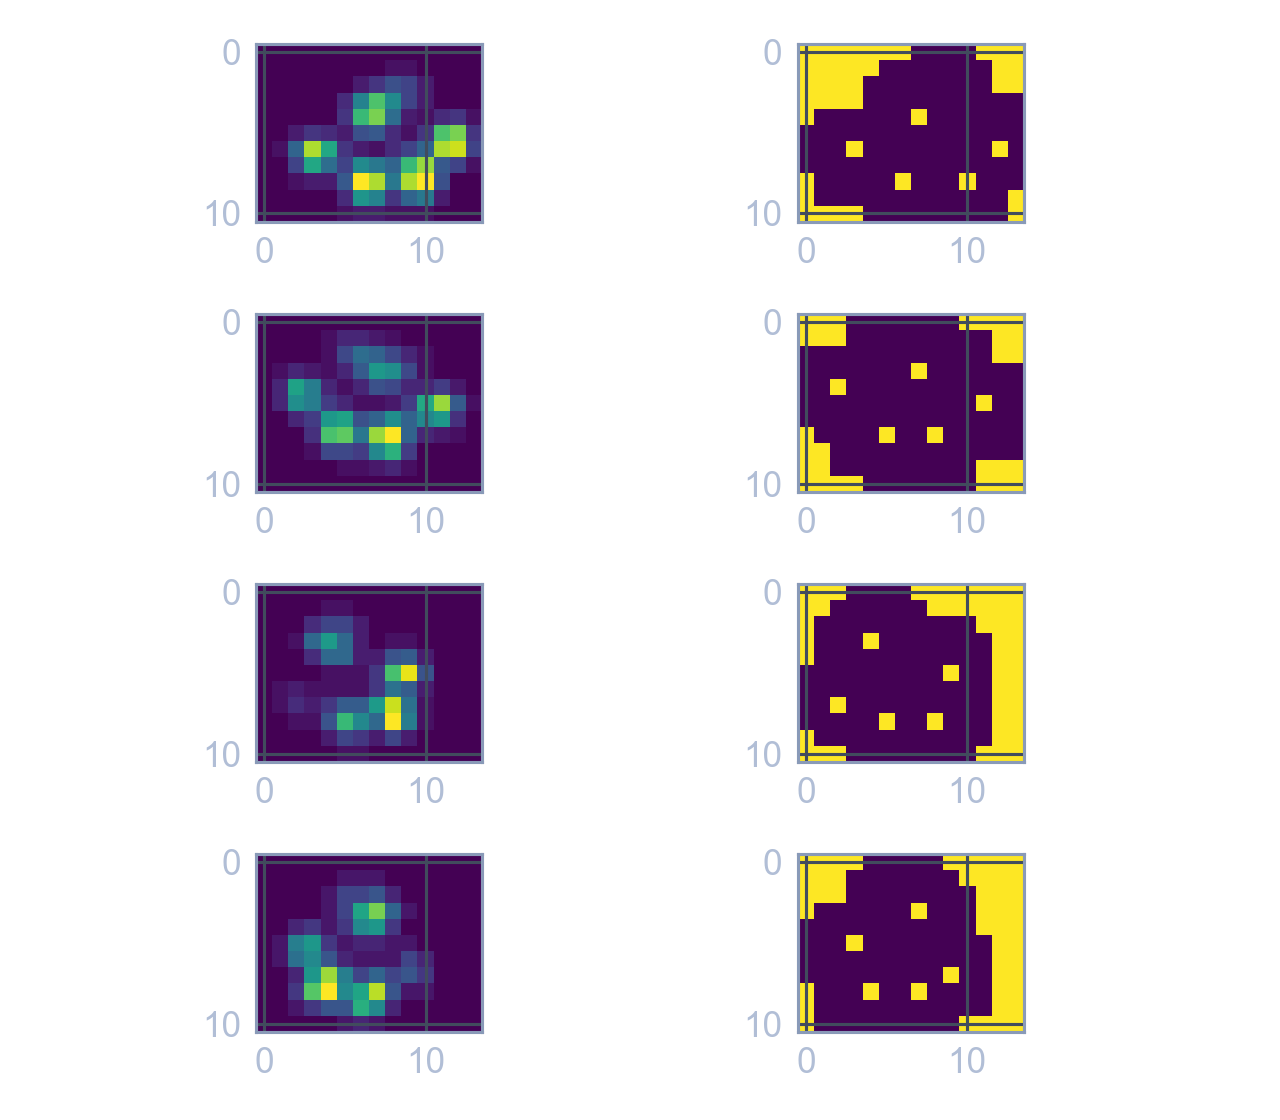

In [19]:
# SOLUTION
plot_compare(paws, local_peaks_v1);

What do you see in these right-column images? Are these precisely the results we are looking for? What do we need to add to our algorithm, if anything?
> SOLUTION: No, the regions of the image that are blanketed in background (== 0) are also considered to be local peaks, since there are no smaller or larger points in their vicinity. We need to subtract out the background from the image. We can do this by finding `foreground = (data > 0)`, and requiring that the returned values are local peaks *and* are located in the foreground.

In [21]:
# SOLUTION
def local_peaks_v2(data):
    """ Find local peaks in a 2D array of data.
    
        Parameters
        ----------
        data : numpy.ndarray
        
        Returns
        -------
        Binary indicator, of the same shape as `data`. The value of
        1 indicates a local peak. """
    fp = generate_binary_structure(2, 2)
    local = data == maximum_filter(data, footprint=fp)
    foreground = data > 0
    
    # (x & y) is equivalent to np.logical_and(x, y)
    return local & foreground

<IPython.core.display.Javascript object>


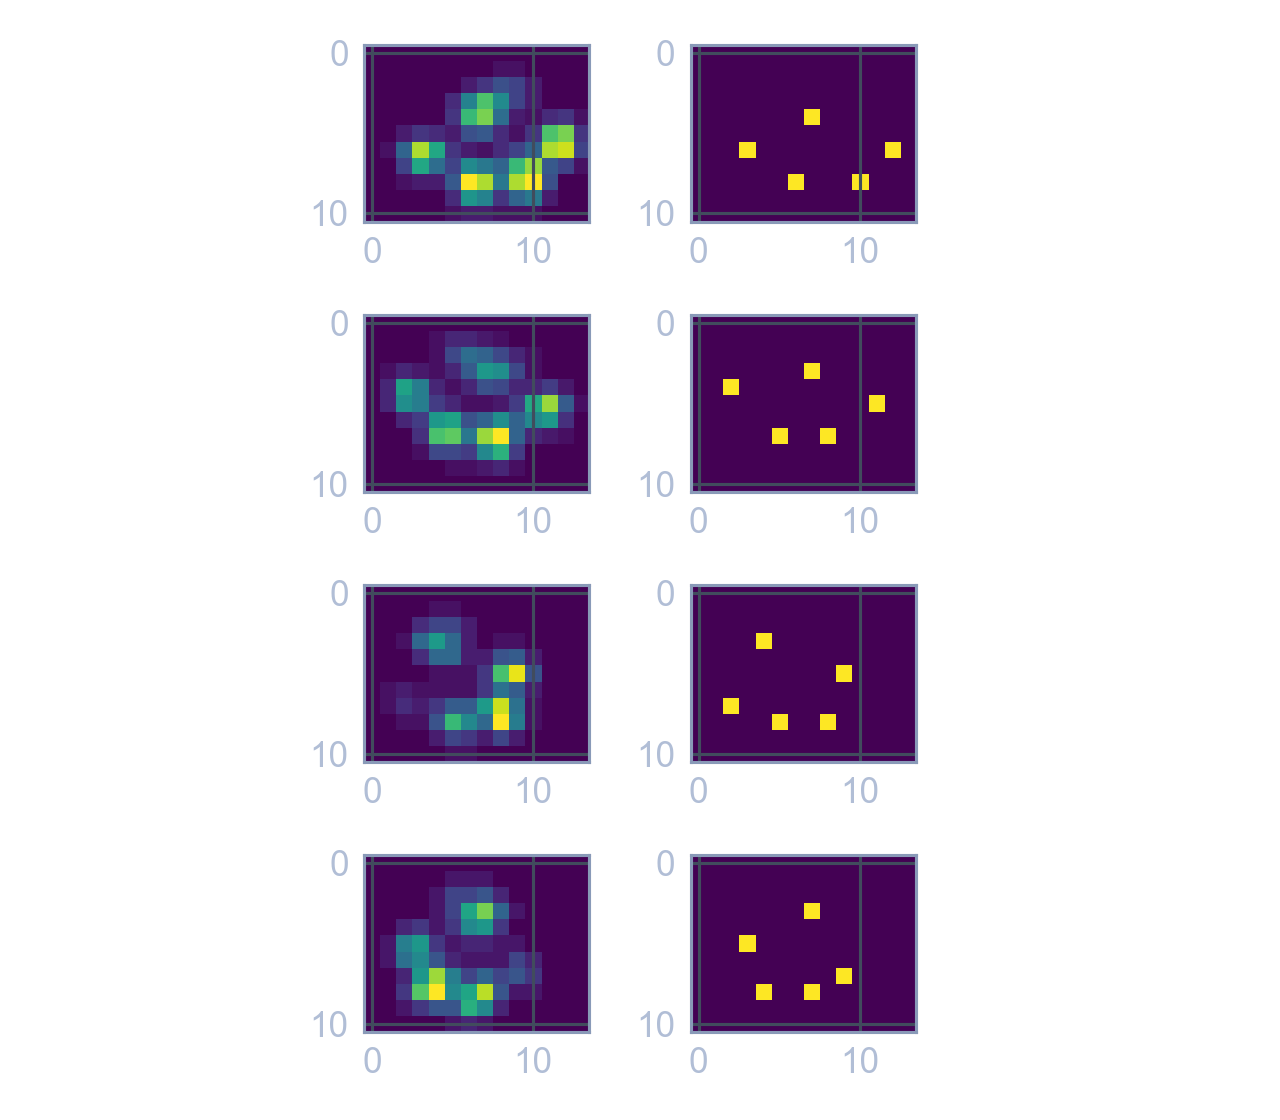

In [22]:
# SOLUTION
plot_compare(paws, local_peaks_v2);

Success! We are now finding local peaks in 2D data!

To summarize this process, we:
 - Determined a neighborhood that was appropriate for measuring local peaks.
 - Created a max-filtered version of our data.
 - Found the local peaks by finding where the data and the max-filtered data agree.
 - Demanded that our local peaks be in the "foreground" of our data.
 
This will be very useful to help us find the "fingerprint features" of a song, given its spectrogram (frequency vs time) data.